In [6]:
import pickle
from rassp import netutil
import os
import torch

use_gpu=True
#model_dir='checkpoints'
model_dir='zia5'


MODELS = {
    'FormulaNet': {
        'checkpoint': os.path.join(model_dir, 'test.79149399.00000000.model'),
        'meta': os.path.join(model_dir, 'test.79149399.meta'),

        # NOTE(2023-01-24): FN currently has a reduced set of valid mol constraints bc this is what we trained with
        # and there is currently an outstanding bug where changing N_ATOMS here breaks FN predictions in subtle ways.
        'override_constraints': {
            'n_atom': 48,
            # 'n_formula': 4096,
            'n_formula': 100000,
            # 'n_subset': 12288,
            'n_subset': 49152,
        },
    },
}

model_name='FormulaNet'
meta_path = MODELS[model_name]['meta']
ckpt_path = MODELS[model_name]['checkpoint']
override_constraints = MODELS[model_name]['override_constraints']
meta = pickle.load(open(meta_path, 'rb'))

feat_config = meta['featurize_config']
for key, val in override_constraints.items():
    if key == 'n_atom':
        feat_config['MAX_N'] = val
    if key == 'n_formula':
        feat_config['explicit_formulae_config']['max_formulae'] = val
    if key == 'n_subset':
        feat_config['vert_subset_samples_n'] = val

if use_gpu and not torch.cuda.is_available():
    use_gpu = False

predictor = netutil.PredModel(
    meta_path,
    ckpt_path,
    USE_CUDA=use_gpu,
    data_parallel=False,
    featurize_config_update=feat_config,
)


In [1]:
import pandas as pd
trd = pd.read_parquet('test.pq')

In [23]:
from rdkit import Chem

molidx = [ 14,42,815,1414 ]

smiles = list(trd.iloc[molidx].smiles)

smiles = ['N#Cc1ccc([nH]1)C(=O)N1CC2C(C1)C2NC(=O)CCC1CCOC1']
#smiles = ['CC(=O)NC(=O)c1cc2ccc(cc2oc1=Nc1ccc(cc1Cl)Cl)OC(=O)C']
valid_mols = [ Chem.AddHs(Chem.MolFromSmiles(s)) for s in smiles ]

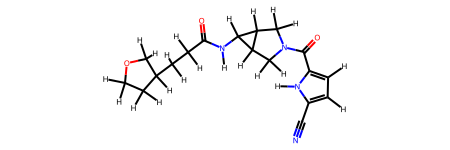

In [24]:
valid_mols[0]

In [25]:
predictions = predictor.pred(
    valid_mols,
    progress_bar=True,
    normalize_pred=True,
    output_hist_bins=True,
    batch_size=1, # XXX
    dataloader_config={
        'pin_memory': False,
        'num_workers': 0, # XXX
        'persistent_workers': False,
    },
    benchmark_dataloader=False,
)

100%|███████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.54it/s]


ImportError: cannot import name 'plot_spectra' from 'matchms' (/opt/conda/lib/python3.8/site-packages/matchms/__init__.py)

In [8]:
idx=0

shit_nist=trd[trd.smiles == smiles[idx]]
shit_nist

,rdmol,spect,smiles


In [7]:
idx2=0

In [13]:
import matchms
import numpy as np

mzi=np.array(list(shit_nist.iloc[idx2].spect))
shit1 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
mzi=predictions['pred_binned'][idx].astype(float)
shit2 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])

NameError: name 'idx2' is not defined

2023-03-24 09:57:10,944:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2023-03-24 09:57:10,944 - matchms - WARNING - No precursor_mz found in metadata.


(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum'}, xlabel='m/z', ylabel='Intensity'>)

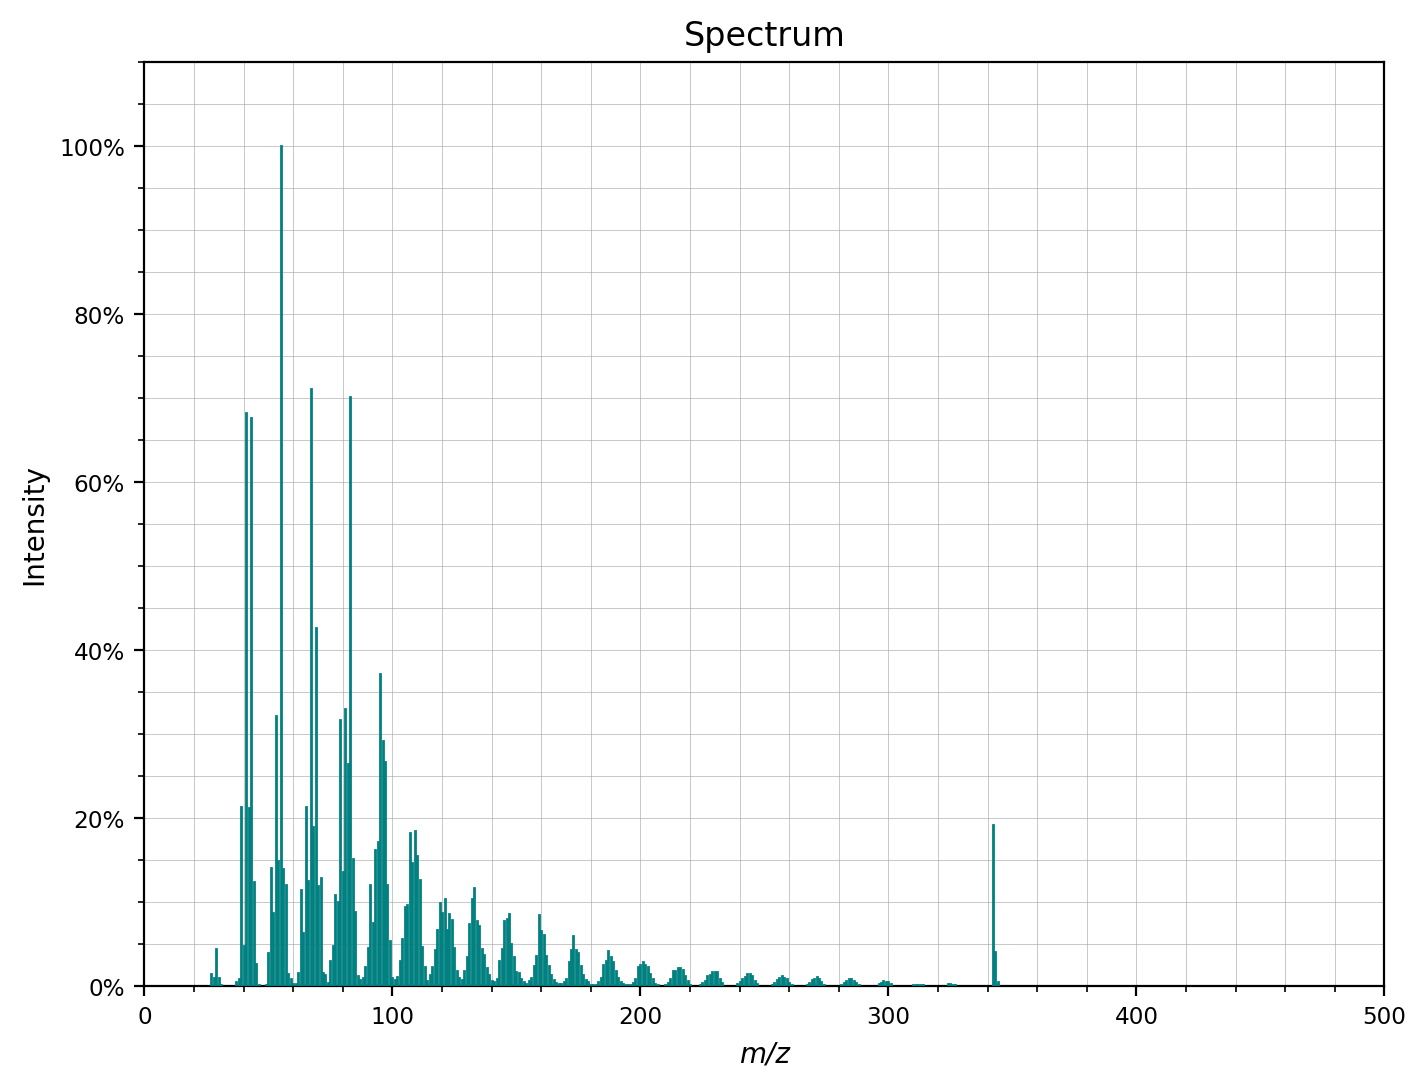

In [26]:
mzi=predictions['pred_binned'][idx].astype(float)
shit2 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
shit2.plot()

<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

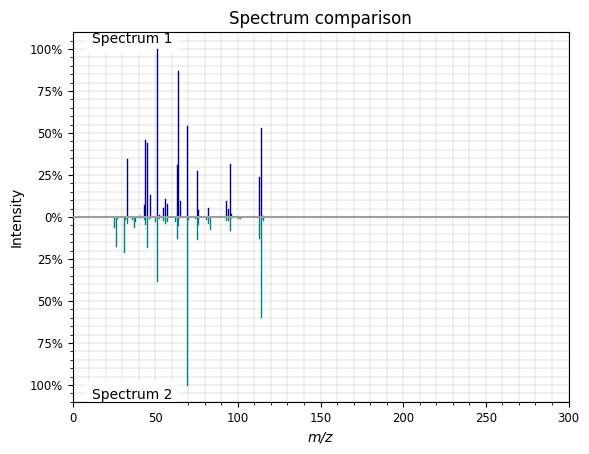

In [9]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

In [ ]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

In [ ]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

In [ ]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)

In [ ]:
idx=2
idx2=0
shit_nist=trd[trd.smiles == smiles[idx]]
mzi=np.array(list(shit_nist.iloc[idx2].spect))
shit1 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
mzi=predictions['pred_binned'][idx].astype(float)
shit2 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
plot_spectra_mirror(shit1,shit2)

In [13]:
predictions

{}

In [17]:
list(map(lambda p: p.astype(float),predictions['pred_binned']))

[array([[1.00000000e+00, 4.05882238e-05],
        [1.20000000e+01, 1.03801182e-02],
        [1.30000000e+01, 5.02983574e-03],
        [1.40000000e+01, 5.31718506e-05],
        [1.90000000e+01, 4.39986074e-03],
        [2.00000000e+01, 1.34620845e-04],
        [2.40000000e+01, 2.37587914e-02],
        [2.50000000e+01, 4.77210246e-02],
        [2.60000000e+01, 1.02102547e-03],
        [3.10000000e+01, 4.03453767e-01],
        [3.20000000e+01, 8.23747441e-02],
        [3.30000000e+01, 8.43513582e-04],
        [4.30000000e+01, 1.16897844e-01],
        [4.40000000e+01, 2.97511011e-01],
        [4.50000000e+01, 6.38006767e-03]]),
 array([[1.00000000e+00, 1.18477612e-06],
        [2.00000000e+00, 1.42983527e-06],
        [3.00000000e+00, 3.32685840e-06],
        [1.20000000e+01, 1.05999025e-05],
        [1.30000000e+01, 9.75807416e-06],
        [1.40000000e+01, 1.70982996e-04],
        [1.50000000e+01, 2.62090564e-03],
        [1.60000000e+01, 5.43861534e-04],
        [1.70000000e+01, 4.31834